# Using the Segmentation Models Package
https://www.kaggle.com/cdeotte/keras-unet-with-eda

In [1]:
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
base_dir = '/data/severstal-steel-defect-detection/'

In [3]:
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt, time
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

path = base_dir
train = pd.read_csv(path + 'train.csv')

# RESTRUCTURE TRAIN DATAFRAME
train['ImageId'] = train['ImageId_ClassId'].map(lambda x: x.split('.')[0]+'.jpg')
train2 = pd.DataFrame({'ImageId':train['ImageId'][::4]})
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

,ImageId,e1,e2,e3,e4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1
1,00031f466.jpg,,,,,0
2,000418bfc.jpg,,,,,0
3,000789191.jpg,,,,,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1


In [4]:
from tqdm import tqdm

In [5]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [6]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

In [7]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from keras.utils import multi_gpu_model
import tensorflow as tf
# LOAD UNET WITH PRETRAINING FROM IMAGENET

with tf.device('/cpu:0'):
    preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
    model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
    

parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

del model

model = parallel_model
del parallel_model

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); print()
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)

In [12]:
history = model.fit_generator(
    train_batches, 
    validation_data = valid_batches, 
    epochs = 30, 
#     verbose=0, 
#     callbacks=[TQDMNotebookCallback()]
)

Epoch 1/30
628/628 [==============================] - 151s 240ms/step - loss: 0.0294 - dice_coef: 0.1569 - val_loss: 0.0286 - val_dice_coef: 0.2069
Epoch 2/30
628/628 [==============================] - 146s 233ms/step - loss: 0.0237 - dice_coef: 0.2608 - val_loss: 0.0241 - val_dice_coef: 0.2790
Epoch 3/30
628/628 [==============================] - 148s 235ms/step - loss: 0.0206 - dice_coef: 0.3383 - val_loss: 0.0246 - val_dice_coef: 0.2906
Epoch 4/30
628/628 [==============================] - 148s 236ms/step - loss: 0.0191 - dice_coef: 0.3737 - val_loss: 0.0208 - val_dice_coef: 0.3491
Epoch 5/30
628/628 [==============================] - 149s 238ms/step - loss: 0.0176 - dice_coef: 0.4091 - val_loss: 0.0231 - val_dice_coef: 0.2601
Epoch 6/30
628/628 [==============================] - 149s 237ms/step - loss: 0.0163 - dice_coef: 0.4439 - val_loss: 0.0225 - val_dice_coef: 0.3174
Epoch 7/30
628/628 [==============================] - 147s 235ms/step - loss: 0.0155 - dice_coef: 0.4648 - val_l

In [13]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

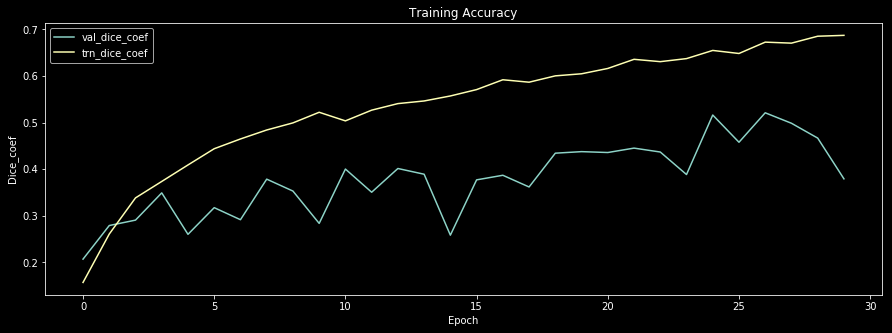

In [14]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()